# Estimating major event impact on German electricity prices
Notebook 03 splitting and pre-processing
___

### Table of Contents:
* [Introduction](#hading-1)
* [Pre-processing](#heading-2)
* [Split](#heading-3)
* [Export](#heading-4)

### Introduction <a class="anchor" id="heading-1"></a>

After the [EDA](02-eda.ipynb), we will now deal with the quantification of the influences. To do this, our dataset is prepared for modeling in the following notebook.
We will divide the data period into two areas.

![alt text](../images/image-1.png)

A brief review. The adjusted prices for electricity in Germany from 2015 to mid-2021 show no special features and are relatively constant. From the end of 2021 we see massive price outliers, we will quantify the influence of certain events on the price during this period.


For this purpose, a model is built that predicts electricity prices based on the normal range between 2015 and mid-2021 in the range 2022 to 2024.

Two approaches are pursued

- Approach no. 1 only refers to the price in our target region, i.e. only historical price data from Germany and Luxembourg is included in the forecast. 

 - Approach no. 2, on the other hand, includes all available data in the modelling. It will include generation, import-export and the price in other zones.

### Import libraries 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import datetime as dt

plt.rcParams.update({'font.size': 10})

### Functions 

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose 
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import month_plot


def decomposition_df(df, column, frequency='MS',aggregation_method='sum', type='additive'):
    '''
    Process a dataframe to decompose its time series data and add trend, seasonal, residual, and trend+seasonal columns.
    
    Parameters:
    - df: pandas DataFrame containing the data to be processed
    - column: the column to be processed in the dataframe
    - frequency: the frequency of the decomposition, default monthly 
        - D - daily
        - h- hourly
        - W- weekly 

        look here: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects
    -aggregation_method: the method of the decomposition, default sum
        -mean
        -min
        -max


    -type: the used model in the decomposition, default = additive
        - multiplicative 
    
    
    Returns:
    - df_Frequency: the processed DataFrame with additional columns
    '''
    aggregation_func = getattr(pd.DataFrame, aggregation_method)
    df_Frequency=df[[column]].resample(frequency).apply(aggregation_func)
    decompositon= seasonal_decompose(df_Frequency[column], model=type)


    df_Frequency['Trend'] = decompositon.trend
    df_Frequency['Seasonal'] = decompositon.seasonal
    df_Frequency['Residual'] = decompositon.resid
    df_Frequency['Trend+Seasonal'] = df_Frequency['Seasonal'] + df_Frequency['Trend']

    return df_Frequency

In [3]:
def data_loading_and_set_index(df_name, base_path = '../data/', type = '_eda'):
    '''
    loads the dataframe df from the base_path and set_the 'Start' column as the index in datetime format.

    df_name: expect a df Name for example Prices_FRA_hourly
    base_path default: '../data/' 

    return Prices_FRA_hourly
    '''
    
    file_path = f"{base_path}{df_name}.csv"
    df= pd.read_csv(file_path)
    if 'Unnamed: 0' in df.columns:
        df['Start'] = pd.to_datetime(df['Unnamed: 0'])
        df = df.drop(columns = 'Unnamed: 0')
        df = df.set_index('Start')
    else:
        df['Start'] = pd.to_datetime(df['Start'])
        df = df.set_index('Start')

    return df

In [4]:
def train_test_splitter(df, date = '2021-03-21 00:00:00'):
    '''
    takes a dataframe df and splits it at a custome date into df1, df2 as return
    '''
    df1 = df.loc[df.index <= date]
    df2 = df.loc[df.index > date]

    return df1, df2

### Import

In [5]:
Consumption = data_loading_and_set_index('Consumption_eda')
Generation = data_loading_and_set_index('Generation_eda')
Export_Import = data_loading_and_set_index('Export_Import_eda')
Prices = data_loading_and_set_index('Prices_eda')
Inflation_index = data_loading_and_set_index('Inflation_index')

In [6]:
co2_Prices = pd.read_csv('../data/co2_Prices.csv')
co2_Prices['Start'] = pd.to_datetime(co2_Prices['Date'])
co2_Prices = co2_Prices.drop(columns = 'Date')
co2_Prices = co2_Prices.set_index('Start')

### Pre-processing <a class="anchor" id="heading-2"></a>

To build the model, the time period must be divided into the normal and the non-normal area.To determine the date of change, the following analysis is performed.

In [7]:
Prices_GER_weekly_co2 = decomposition_df(Prices, 'Germany_Luxembourg_co2_adjusted', 'W', 'mean')

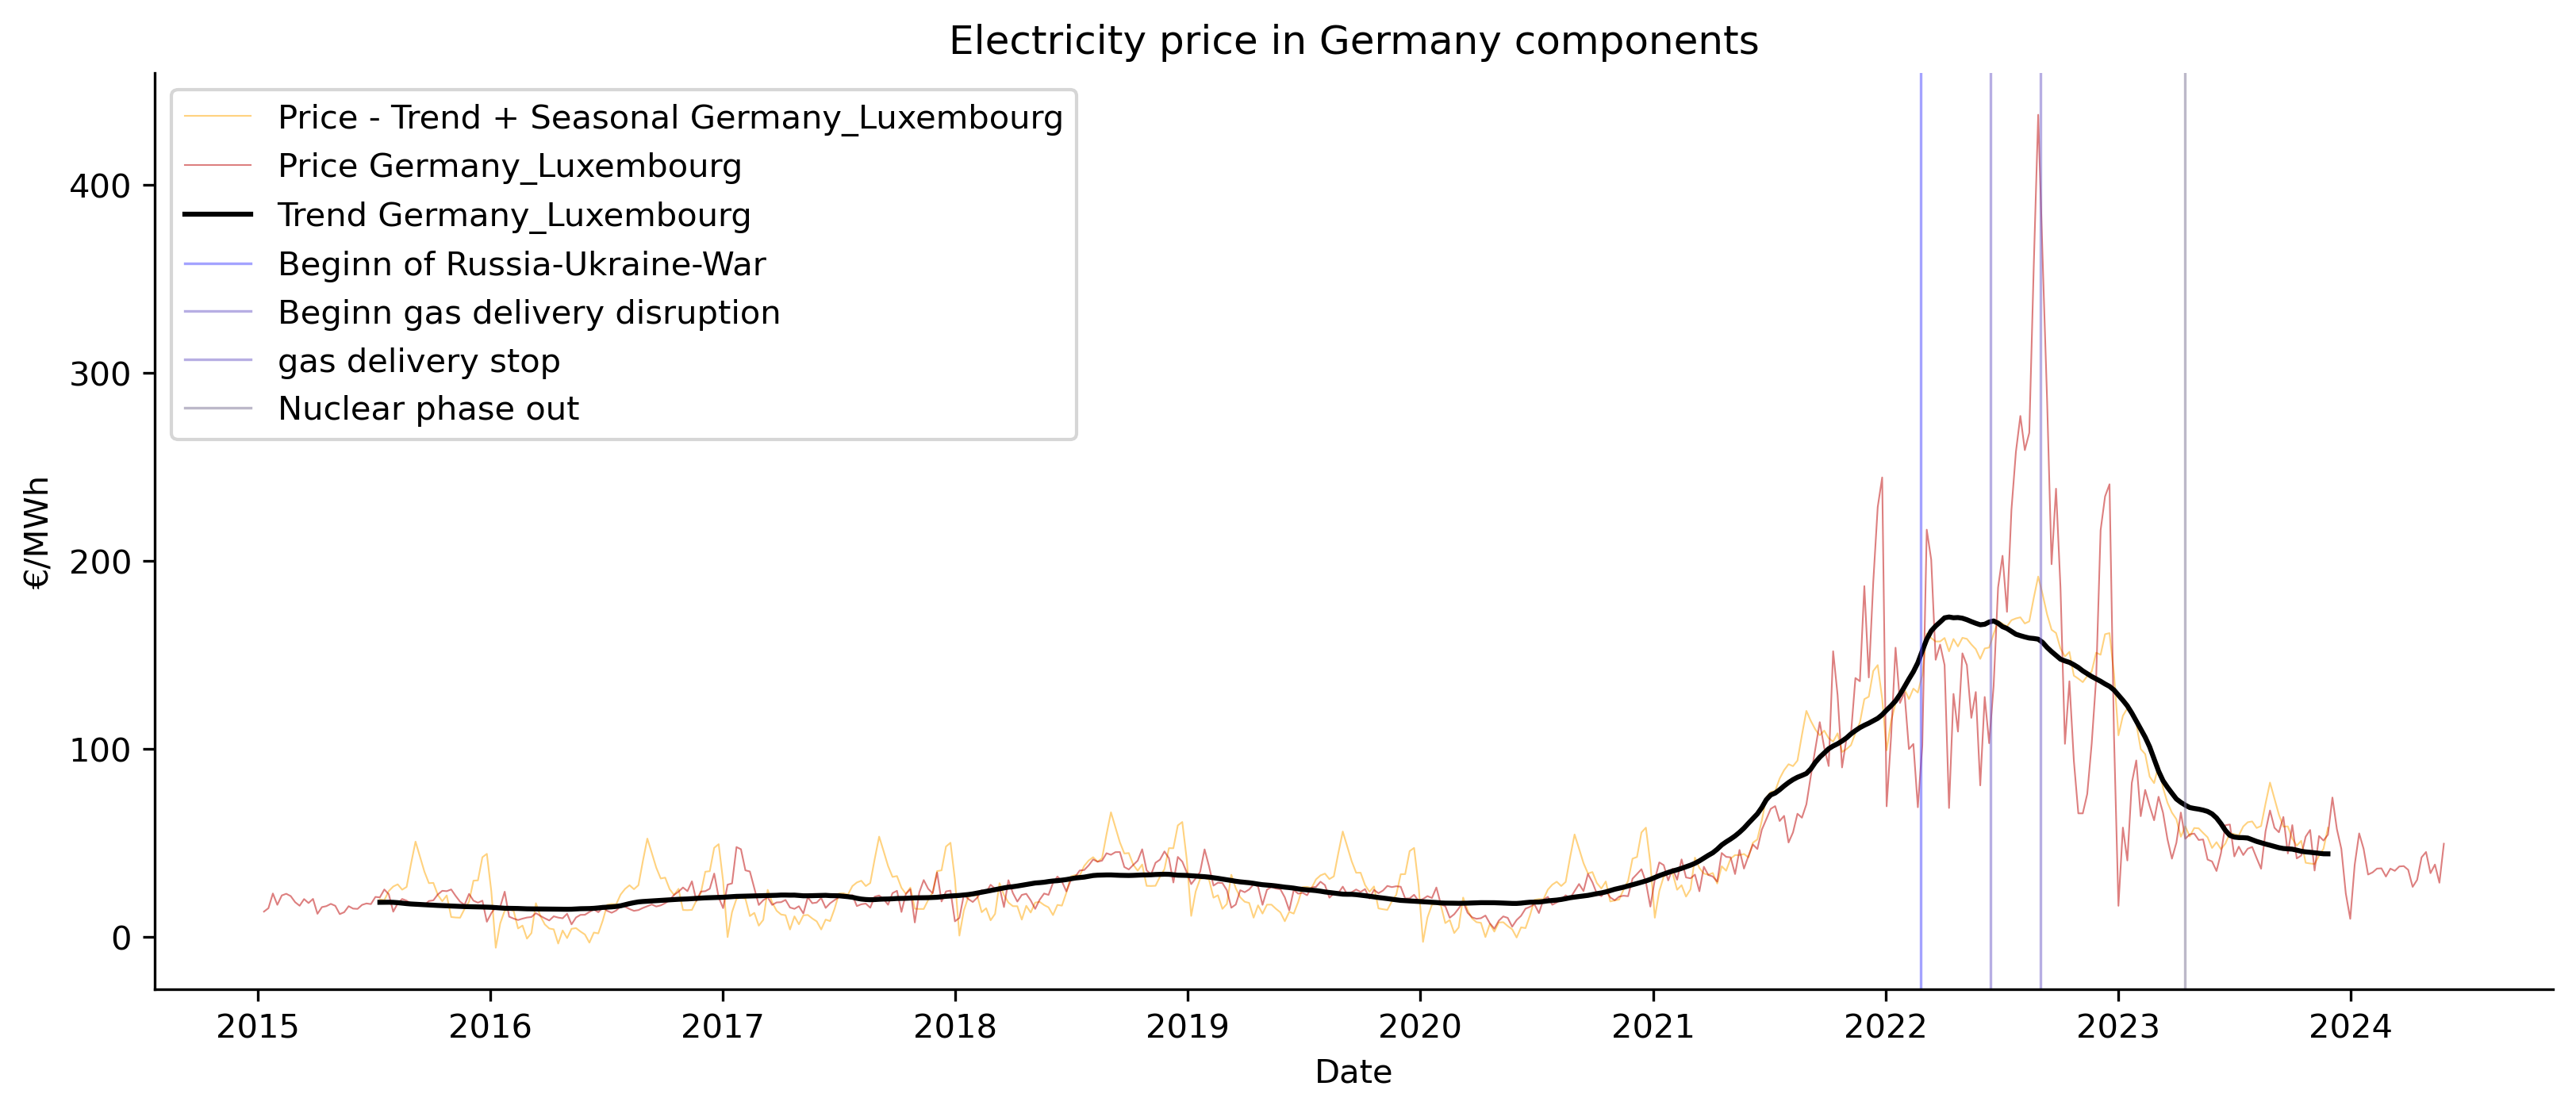

In [8]:
plt.figure(figsize= (13,5), dpi = 300)

plt.plot(Prices_GER_weekly_co2['Trend+Seasonal'], label = 'Price - Trend + Seasonal Germany_Luxembourg', color = '#ffa600',alpha = .5, linewidth = 0.5 )
plt.plot(Prices_GER_weekly_co2['Germany_Luxembourg_co2_adjusted'], label = 'Price Germany_Luxembourg',color='#bc0000', alpha = .5, linewidth = 0.5 )
plt.plot(Prices_GER_weekly_co2['Trend'], label = 'Trend Germany_Luxembourg',color='#000000')# ,alpha = .2, linewidth = 0.5 )


plt.axvline(x=dt.datetime(2022,2,24),color = '#4a48ff', alpha = .5, linewidth = .8,  label = 'Beginn of Russia-Ukraine-War')
plt.axvline(x=dt.datetime(2022,6,14),color = '#705ec9', alpha = .5, linewidth = .8,  label = 'Beginn gas delivery disruption')
plt.axvline(x=dt.datetime(2022,8,31),color = '#705ec9', alpha = .5, linewidth = .8,  label = 'gas delivery stop')
plt.axvline(x=dt.datetime(2023,4,15),color = '#7b7294', alpha = .5, linewidth = .8,  label = 'Nuclear phase out')

plt.title('Electricity price in Germany components')
plt.ylabel('€/MWh')
plt.xlabel('Date')
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

We see the familiar picture, how do we define the change between normal and non-normal?

Trend based approach

In [9]:
Prices_GER_weekly_co2['Trend_Slope'] = Prices_GER_weekly_co2['Trend'].diff()

We choose the date based on the change in the slope of the trend, to do this we calculate the difference between the current trend value and the previous trend. If the slope is greater than the standard normal distribution, we set the date as the cutoff

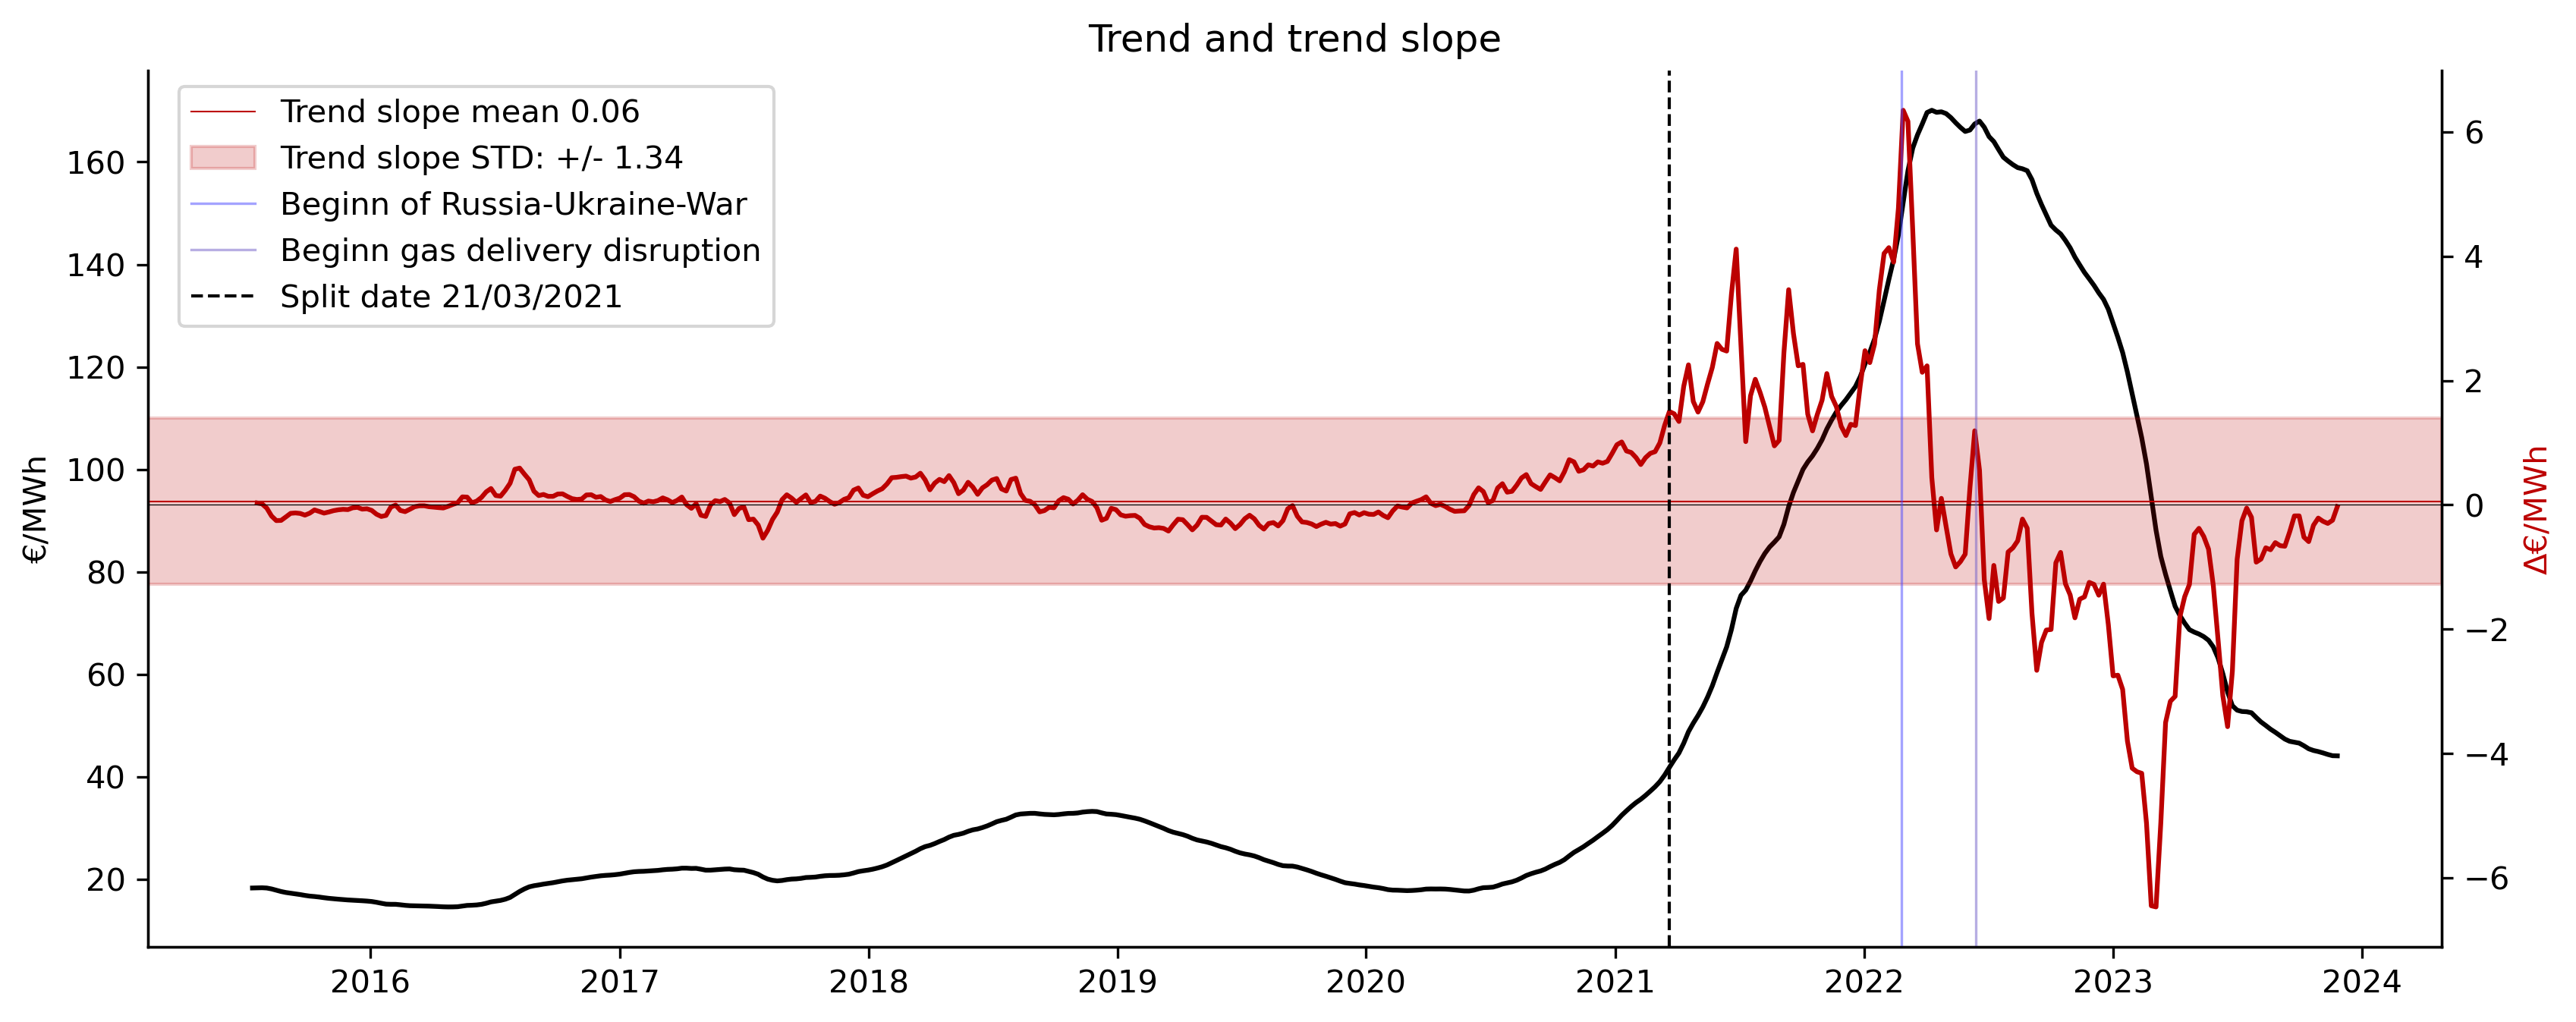

In [16]:
Trend_slope_std = Prices_GER_weekly_co2['Trend_Slope'].std()
Trend_slope_mean = Prices_GER_weekly_co2['Trend_Slope'].mean()


fig, ax1 = plt.subplots(figsize=(13, 5), dpi=300)


ax1.plot(Prices_GER_weekly_co2.index, Prices_GER_weekly_co2['Trend'], color='#000000')
ax1.set_ylabel('€/MWh', color='#000000')


ax2 = ax1.twinx()
ax2.plot(Prices_GER_weekly_co2.index, Prices_GER_weekly_co2['Trend_Slope'], color='#bc0000')

ax2.axhline(y=Trend_slope_mean, color = '#bc0000', linewidth = 0.5, label = f'Trend slope mean {(Trend_slope_mean).round(2)}')
ax2.axhspan(ymin=Trend_slope_mean-Trend_slope_std,ymax=Trend_slope_mean+Trend_slope_std, alpha = 0.2, label = f'Trend slope STD: +/- {(Trend_slope_std).round(2)}',color = '#bc0000')

ax2.axhline(y=0, color = '#000000', linewidth = 0.3)
ax2.set_ylabel('Δ€/MWh', color='#bc0000')

plt.axvline(x=dt.datetime(2022,2,24),color = '#4a48ff', alpha = .5, linewidth = .8,  label = 'Beginn of Russia-Ukraine-War')
plt.axvline(x=dt.datetime(2022,6,14),color = '#705ec9', alpha = .5, linewidth = .8,  label = 'Beginn gas delivery disruption')
#plt.axvline(x=dt.datetime(2023,4,15),color = '#7b7294', alpha = .5, linewidth = .8,  label = 'Nuclear phase out')





plt.axvline(x=dt.datetime(2021,3,21),color = '#000000', alpha = 1, linewidth = 1,linestyle ='--',  label = 'Split date 21/03/2021')
# plt.axvline(x=dt.datetime(2021,7,25),color = '#7b7294', alpha = 1, linewidth = 2) #Split according to residual outliers 

fig.legend(loc = 'upper left', bbox_to_anchor=(0.13, 0.88))
plt.title('Trend and trend slope')


ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.show()

Graphically it looks like this.

Residual based approach

Another approach uses the change in the residuals.

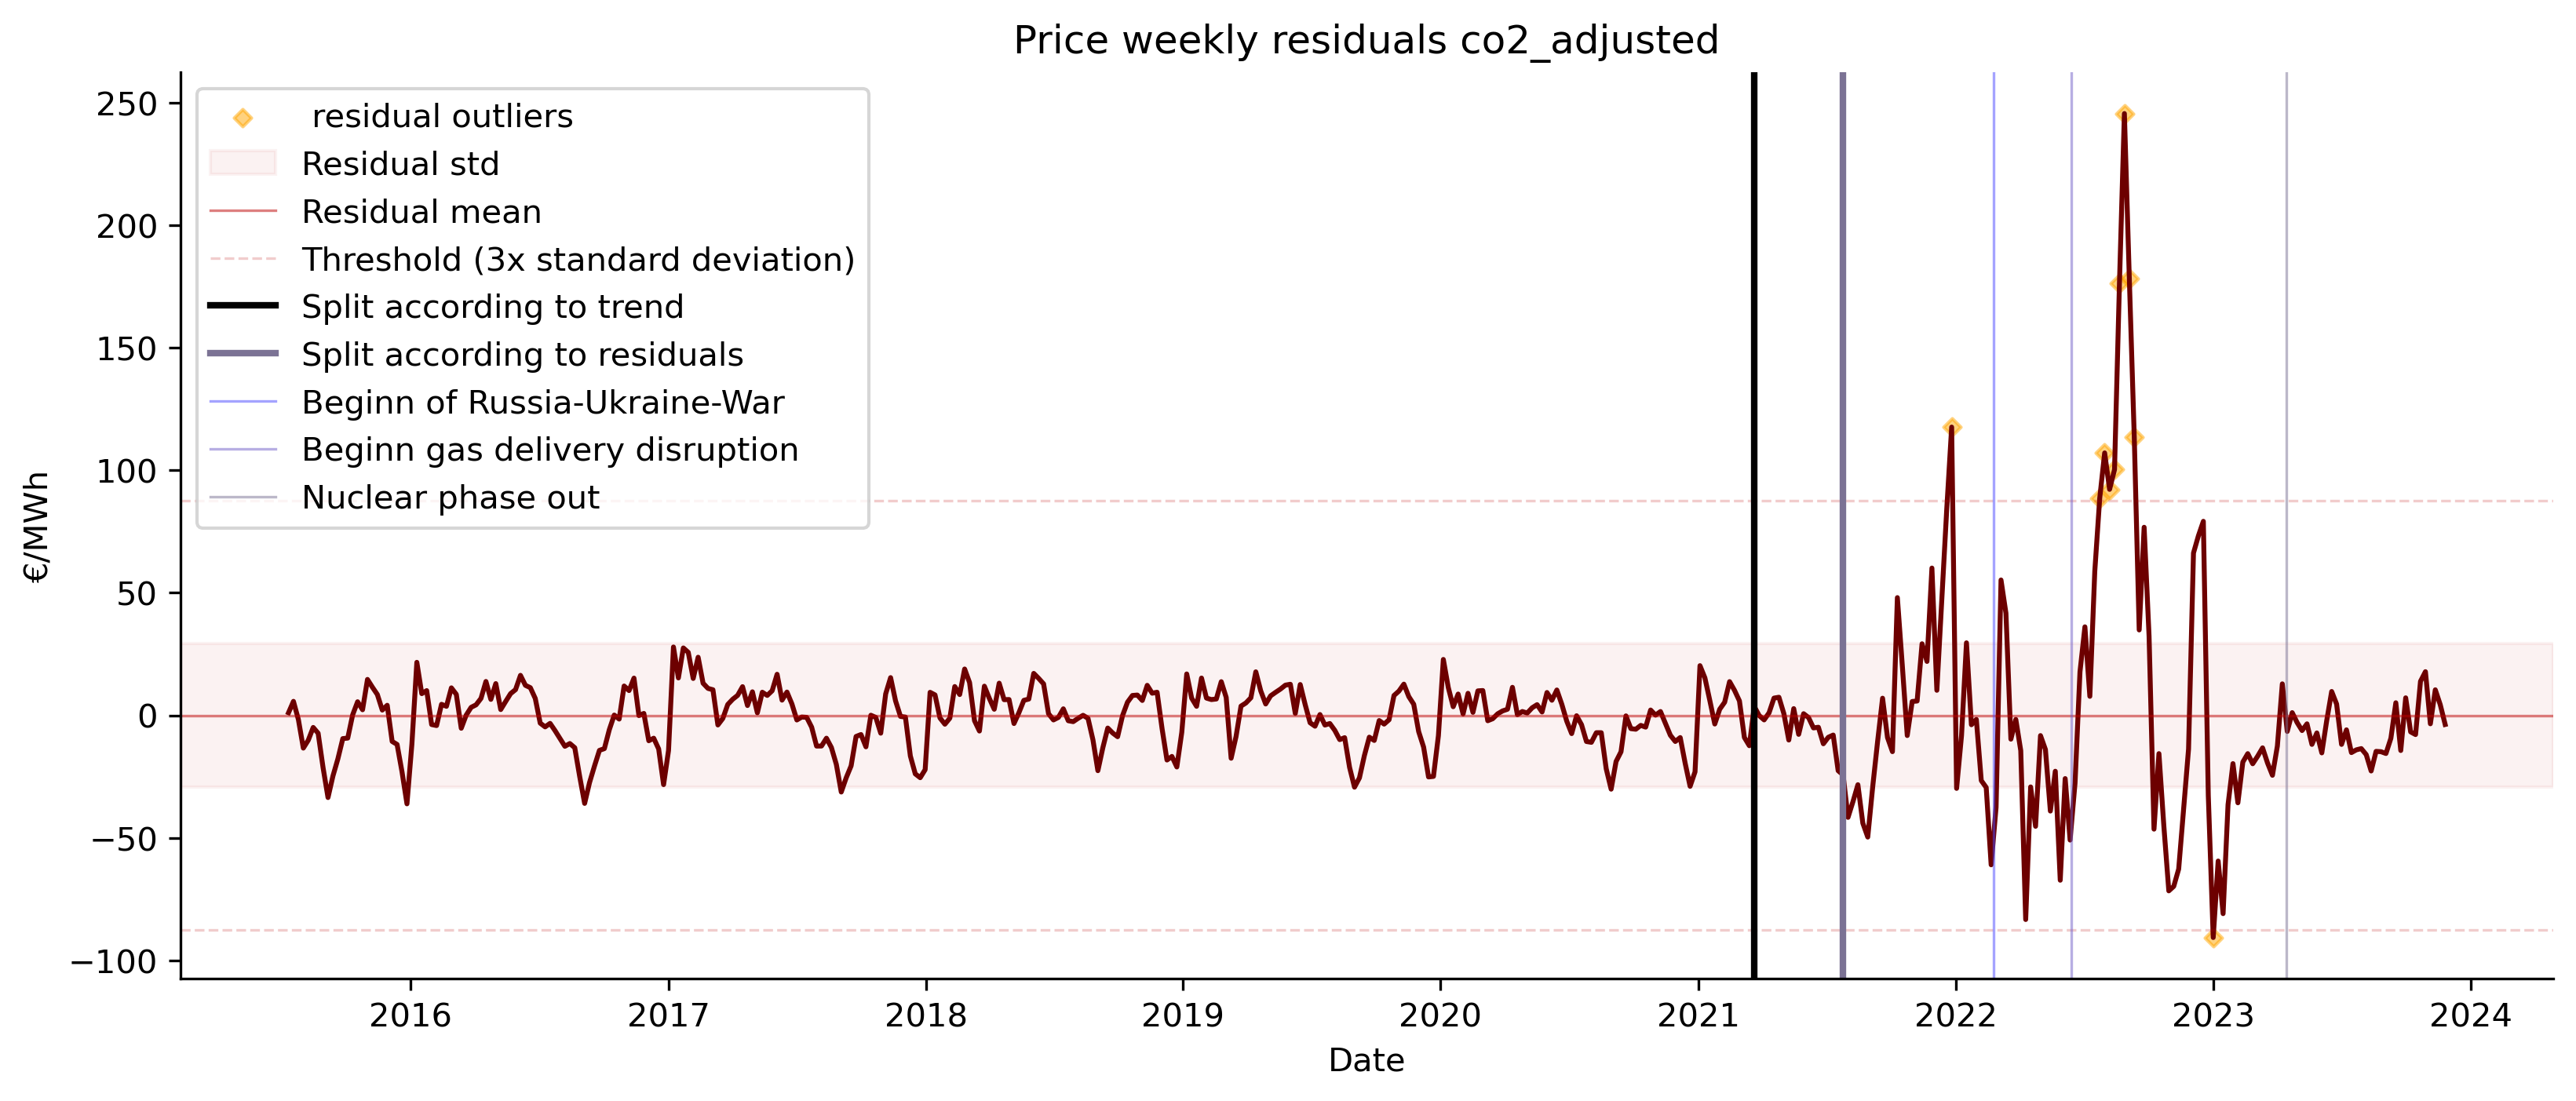

______________________________________________________
mean_Prices_GER_weekly_co2_residual: -0.2
std_Prices_GER_weekly_co2_residual: 29.18


In [11]:
mean_Prices_GER_weekly_co2_residual = np.mean(Prices_GER_weekly_co2['Residual'])
std_Prices_GER_weekly_co2_residual = np.std(Prices_GER_weekly_co2['Residual'])
threshold = std_Prices_GER_weekly_co2_residual*3

marker = Prices_GER_weekly_co2[['Residual']].loc[(Prices_GER_weekly_co2['Residual'] >=3*std_Prices_GER_weekly_co2_residual)|(Prices_GER_weekly_co2['Residual'] <=-3*std_Prices_GER_weekly_co2_residual)].sort_values('Residual', ascending = False)

plt.figure(figsize= (13,5), dpi = 300)

plt.plot(Prices_GER_weekly_co2['Residual'], color = '#6d0000')
plt.scatter(x=marker.index, y= marker['Residual'], color = '#ffa600',alpha = 0.5, s=14,  marker ='D' , label = ' residual outliers')
plt.axhspan(ymin=-std_Prices_GER_weekly_co2_residual,ymax=std_Prices_GER_weekly_co2_residual, alpha = 0.05, label = 'Residual std',color = '#bc0000')
plt.axhline(y=mean_Prices_GER_weekly_co2_residual,color = '#bc0000', alpha = .5, linewidth = .8,  label = 'Residual mean')

plt.axhline(y=threshold,color = '#bc0000', alpha = .2, linewidth = .8,  label = 'Threshold (3x standard deviation)', linestyle = '--')
plt.axhline(y=-threshold,color = '#bc0000', alpha = .2, linewidth = .8, linestyle = '--')



plt.axvline(x=dt.datetime(2021,3,21),color = '#000000', alpha = 1, linewidth = 2, label ='Split according to trend') 
plt.axvline(x=dt.datetime(2021,7,25),color = '#7b7294', alpha = 1, linewidth = 2, label ='Split according to residuals ') 


plt.axvline(x=dt.datetime(2022,2,24),color = '#4a48ff', alpha = .5, linewidth = .8,  label = 'Beginn of Russia-Ukraine-War')
plt.axvline(x=dt.datetime(2022,6,14),color = '#705ec9', alpha = .5, linewidth = .8,  label = 'Beginn gas delivery disruption')
plt.axvline(x=dt.datetime(2023,4,15),color = '#7b7294', alpha = .5, linewidth = .8,  label = 'Nuclear phase out')


plt.legend()
plt.ylabel('€/MWh')
plt.xlabel('Date')
plt.title('Price weekly residuals co2_adjusted')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


print('______________________________________________________')
print(f'mean_Prices_GER_weekly_co2_residual: {(mean_Prices_GER_weekly_co2_residual).round(2)}')
print(f'std_Prices_GER_weekly_co2_residual: {(std_Prices_GER_weekly_co2_residual).round(2)}')


The anomaly in the residuals occurs somewhat later than the anomaly in the trend. A stricter threshold, such as the triple standard normal distribution, could also be chosen.The strong outliers are shown in the table below.

In [12]:
Prices_GER_weekly_co2[['Residual']].loc[(Prices_GER_weekly_co2['Residual'] >=3*std_Prices_GER_weekly_co2_residual)|(Prices_GER_weekly_co2['Residual'] <=-3*std_Prices_GER_weekly_co2_residual)].sort_index(ascending = True)

,Residual
Start,
2021-12-26,117.644090
2022-07-24,88.589672
2022-07-31,107.105137
2022-08-07,92.220328
2022-08-14,100.307436
2022-08-21,176.303032
2022-08-28,245.613287
2022-09-04,178.232689
2022-09-11,113.665064


We choose the earliest changeover point. In a later analysis, a different changeover point could be chosen. However, the goal is to build a model that is as robust as possible, which does not take into account the increase in 2022 and serves as a basis.

### Split <a class="anchor" id="heading-3"></a>

In [13]:
date_range_change = '2021-03-21 00:00:00'
date_range_change_dt = dt.datetime.strptime(date_range_change, '%Y-%m-%d %H:%M:%S')

In [14]:
Prices_train, Prices_test = train_test_splitter(Prices, date = date_range_change)
Consumption_train, Consumption_test = train_test_splitter(Consumption, date = date_range_change)
Generation_train, Generation_test = train_test_splitter(Generation, date = date_range_change)
Export_Import_train, Export_Import_test = train_test_splitter(Export_Import, date = date_range_change)

We split our records according to this date.
![alt text](../images/image-5.png)



### Export <a class="anchor" id="heading-4"></a>

In [15]:
Consumption_test.to_csv('../data/Consumption_test.csv', index = True)
Consumption_train.to_csv('../data/Consumption_train.csv', index = True)
Prices_test.to_csv('../data/Prices_test.csv', index = True)
Prices_train.to_csv('../data/Prices_train.csv', index = True)
Generation_test.to_csv('../data/Generation_test.csv', index = True)
Generation_train.to_csv('../data/Generation_train.csv', index = True)
Export_Import_test.to_csv('../data/Export_Import_test.csv', index = True)
Export_Import_train.to_csv('../data/Export_Import_train.csv', index = True)

___
#### Conclusion / Next Steps

In the next [notebook 04 - modelling-and-findings](04-modelling-and-findings.ipynb), the models are created and compared with each other to find the most robust model, which then predicts in the target space in order to form a difference between what is and what should be.

___